In [1]:
import os

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
SEP         = os.path.sep
ROOT_PATH   = SEP.join(os.getcwd().split(SEP)[:-3])
DATA_PATH   = f'{ROOT_PATH}/Dataset/kidney_stone'
SUBMIT_PATH = 'submissions/kidey_stone'

os.makedirs(SUBMIT_PATH, exist_ok = True)

In [3]:
test_df     = pd.read_csv(f'{DATA_PATH}/test.csv')
train_df    = pd.read_csv(f'{DATA_PATH}/train.csv')
submit_df   = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


In [4]:
def draw_distribution(targets):

    titles = ['whole', 'train', 'valid']
    labels = [0, 1]

    _, axes = plt.subplots(1, 3, figsize = (25, 7))
    for ax, title, target in zip(axes, titles, targets):

        ax.bar(labels, target)
        for lb, trg in zip(labels, target):

            ax.set_title(f'{title} data')
            ax.text(lb, trg, trg,
                    va = 'bottom', ha = 'center')

        
def print_metrics(model, datas):

    tx, vx, ty, vy = datas

    t_pred   = model.predict(tx)
    v_pred   = model.predict(vx)
    
    t_score  = model.score(tx, ty)
    v_score  = model.score(vx, vy)

    t_report = classification_report(ty, t_pred)
    v_report = classification_report(vy, v_pred)

    print(f'train score : {t_score:.3f}')
    print(f'valid score : {v_score:.3f}\n')

    print(f'[train report] \n{t_report} \n')
    print(f'[valid report] \n{v_report}')

    print(f'{"-"*100}\n')


def calculate_metrics(model, datas):

    x, y = datas
    pred = model.predict(x)

    acc = accuracy_score(y, pred)
    f1  = f1_score(y, pred)
    rec = recall_score(y, pred)
    auc = roc_auc_score(y, pred)

    return acc, f1, rec, auc


def grow_tree():

    tree          = {}
    tree['train'] = {}
    tree['valid'] = {}

    tree['train']['acc'] = []
    tree['train']['f1'] = []
    tree['train']['rec'] = []
    tree['train']['auc'] = []

    tree['valid']['acc'] = []
    tree['valid']['f1'] = []
    tree['valid']['rec'] = []
    tree['valid']['auc'] = []

    return tree


def draw_metric_graph(metric_dict, x_values):

    train_metric = metric_dict['train'].items()
    valid_metric = metric_dict['valid'].items()
    _, axes      = plt.subplots(1, 4, figsize = (32, 7))
    
    for ax, train, valid in zip(axes, train_metric, valid_metric):
    
        t_lb, t_data = train
        v_lb, v_data = valid
        
        ax.plot(x_values, t_data, label = 'train')
        ax.plot(x_values, v_data, label = 'valid')
        ax.legend(loc = 'upper right')
        ax.set_title(t_lb)

In [5]:
train_target_cnt = list(train_df.target.value_counts())

train_target = train_df.target
train_data   = train_df.drop('target', axis = 1)

train_x, valid_x, train_y, valid_y = train_test_split(train_data, train_target, random_state = 99,
                                                       stratify = train_target, shuffle = True)

datas       = [train_x, valid_x, train_y, valid_y] 

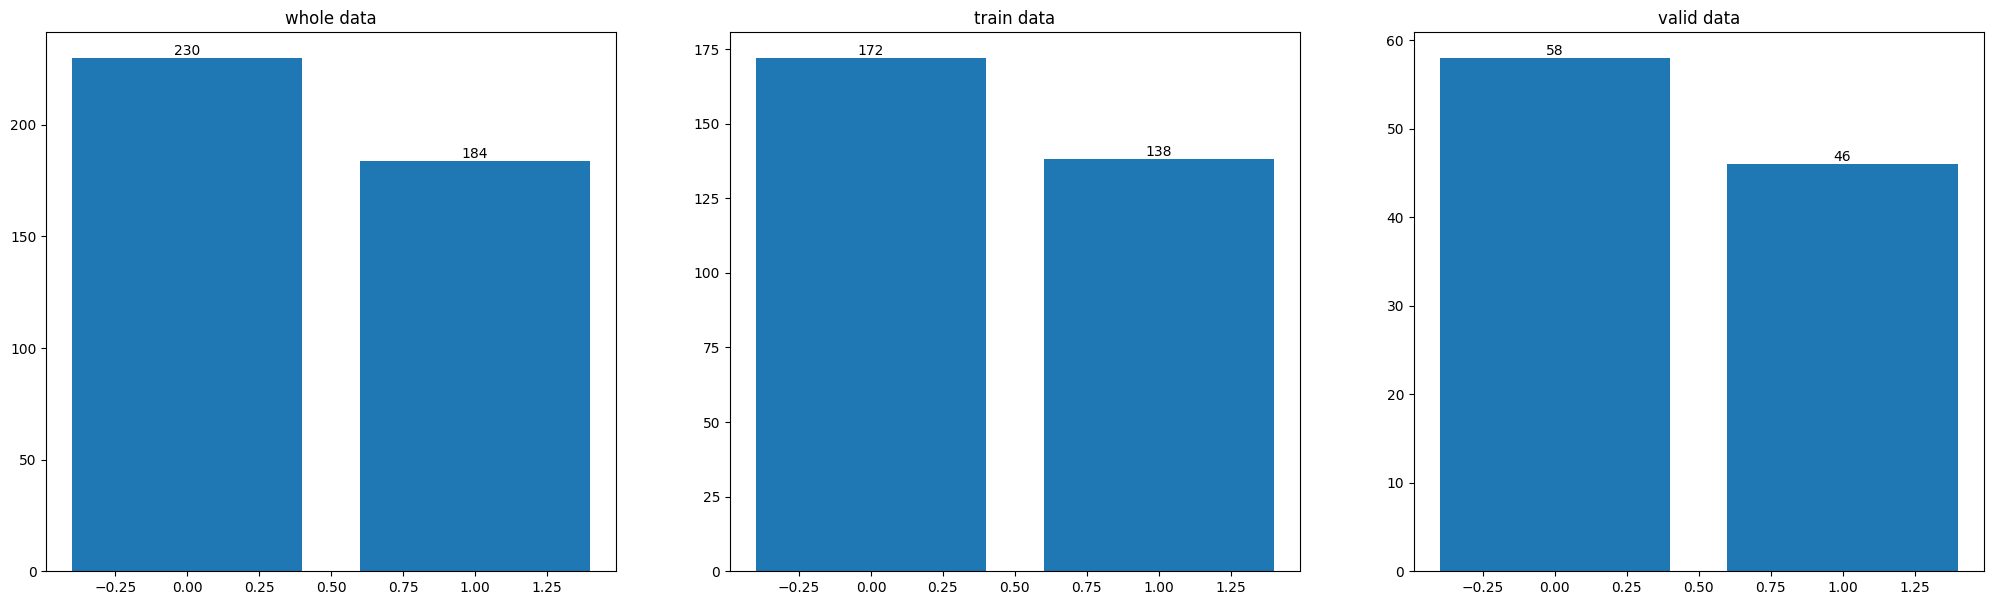

In [6]:
draw_distribution([
                   train_target_cnt      , 
                   train_y.value_counts(), 
                   valid_y.value_counts()
                ])

[k = 1]
train score : 1.000
valid score : 0.558

[train report] 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       172
           1       1.00      1.00      1.00       138

    accuracy                           1.00       310
   macro avg       1.00      1.00      1.00       310
weighted avg       1.00      1.00      1.00       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.60      0.60      0.60        58
           1       0.50      0.50      0.50        46

    accuracy                           0.56       104
   macro avg       0.55      0.55      0.55       104
weighted avg       0.56      0.56      0.56       104

----------------------------------------------------------------------------------------------------

[k = 5]
train score : 0.723
valid score : 0.625

[train report] 
              precision    recall  f1-score   support

           0       0.72      0.81      0.

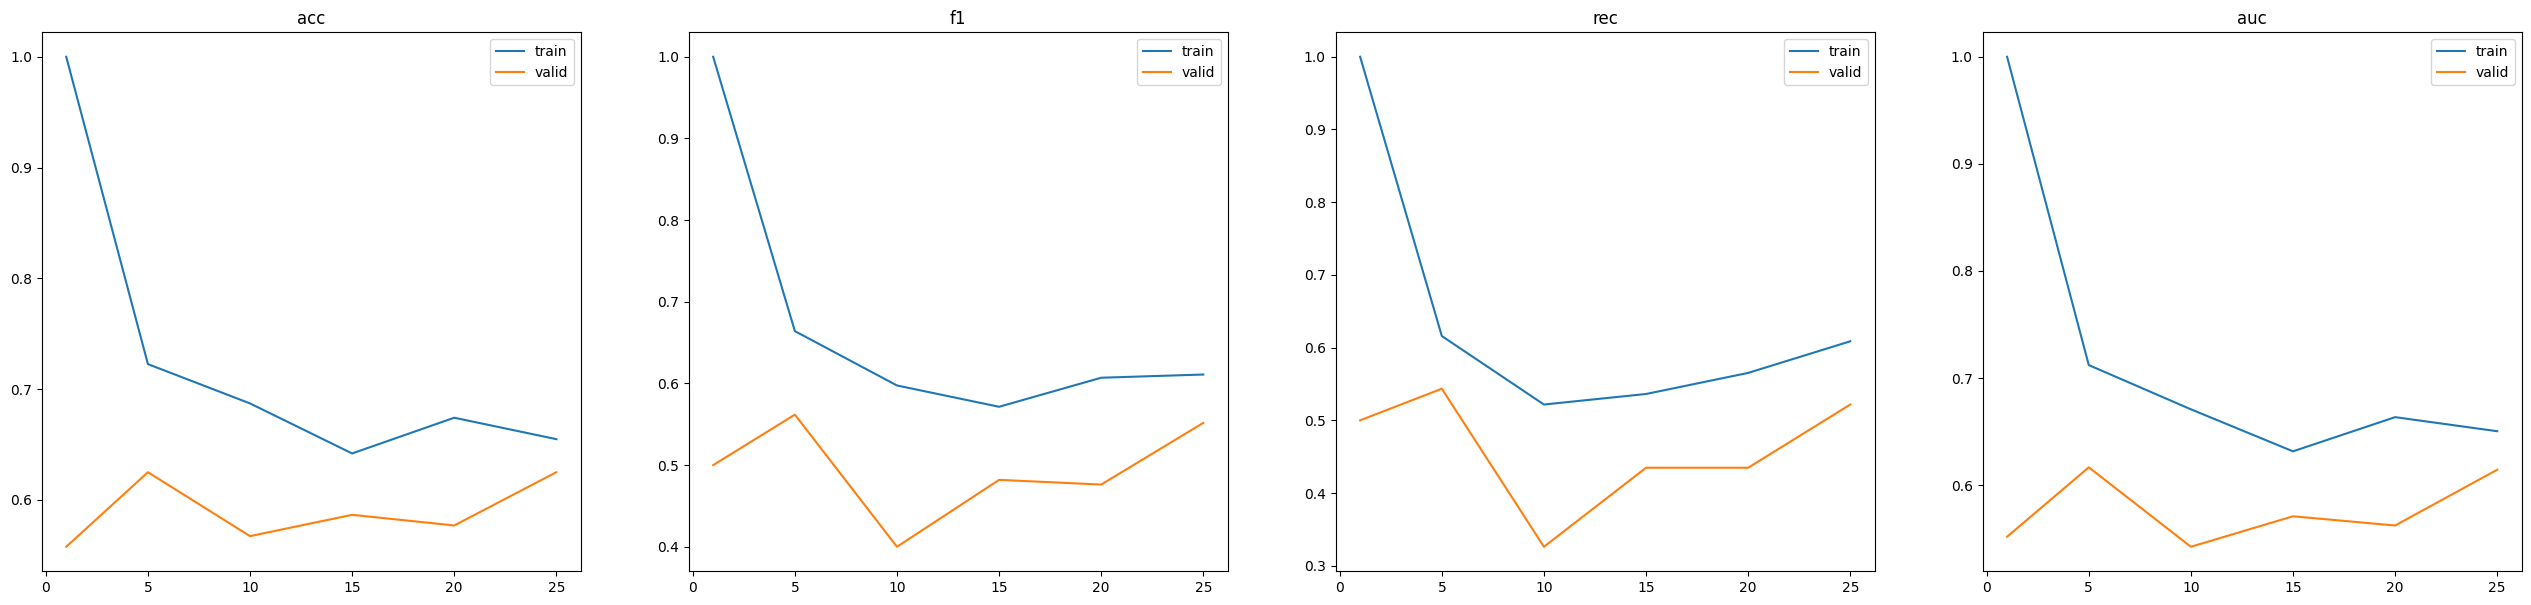

In [7]:
metric_dict = grow_tree()
K = [1, 5, 10, 15, 20, 25]

for k in K:
    print(f'[k = {k}]')
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(train_x, train_y)
    
    print_metrics(knn, datas)
    t_acc, t_f1, t_rec, t_auc = calculate_metrics(knn, (train_x, train_y))
    v_acc, v_f1, v_rec, v_auc = calculate_metrics(knn, (valid_x, valid_y))

    metric_dict['train']['acc'].append(t_acc)
    metric_dict['train']['f1'].append(t_f1)
    metric_dict['train']['rec'].append(t_rec)
    metric_dict['train']['auc'].append(t_auc)
    
    metric_dict['valid']['acc'].append(v_acc)
    metric_dict['valid']['f1'].append(v_f1)
    metric_dict['valid']['rec'].append(v_rec)
    metric_dict['valid']['auc'].append(v_auc)


draw_metric_graph(metric_dict, K)

[C = 0.1]
train score : 0.619
valid score : 0.606

[train report] 
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       172
           1       0.58      0.54      0.56       138

    accuracy                           0.62       310
   macro avg       0.61      0.61      0.61       310
weighted avg       0.62      0.62      0.62       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.63      0.69      0.66        58
           1       0.56      0.50      0.53        46

    accuracy                           0.61       104
   macro avg       0.60      0.59      0.59       104
weighted avg       0.60      0.61      0.60       104

----------------------------------------------------------------------------------------------------

[C = 0.5]
train score : 0.639
valid score : 0.596

[train report] 
              precision    recall  f1-score   support

           0       0.69      0.64    

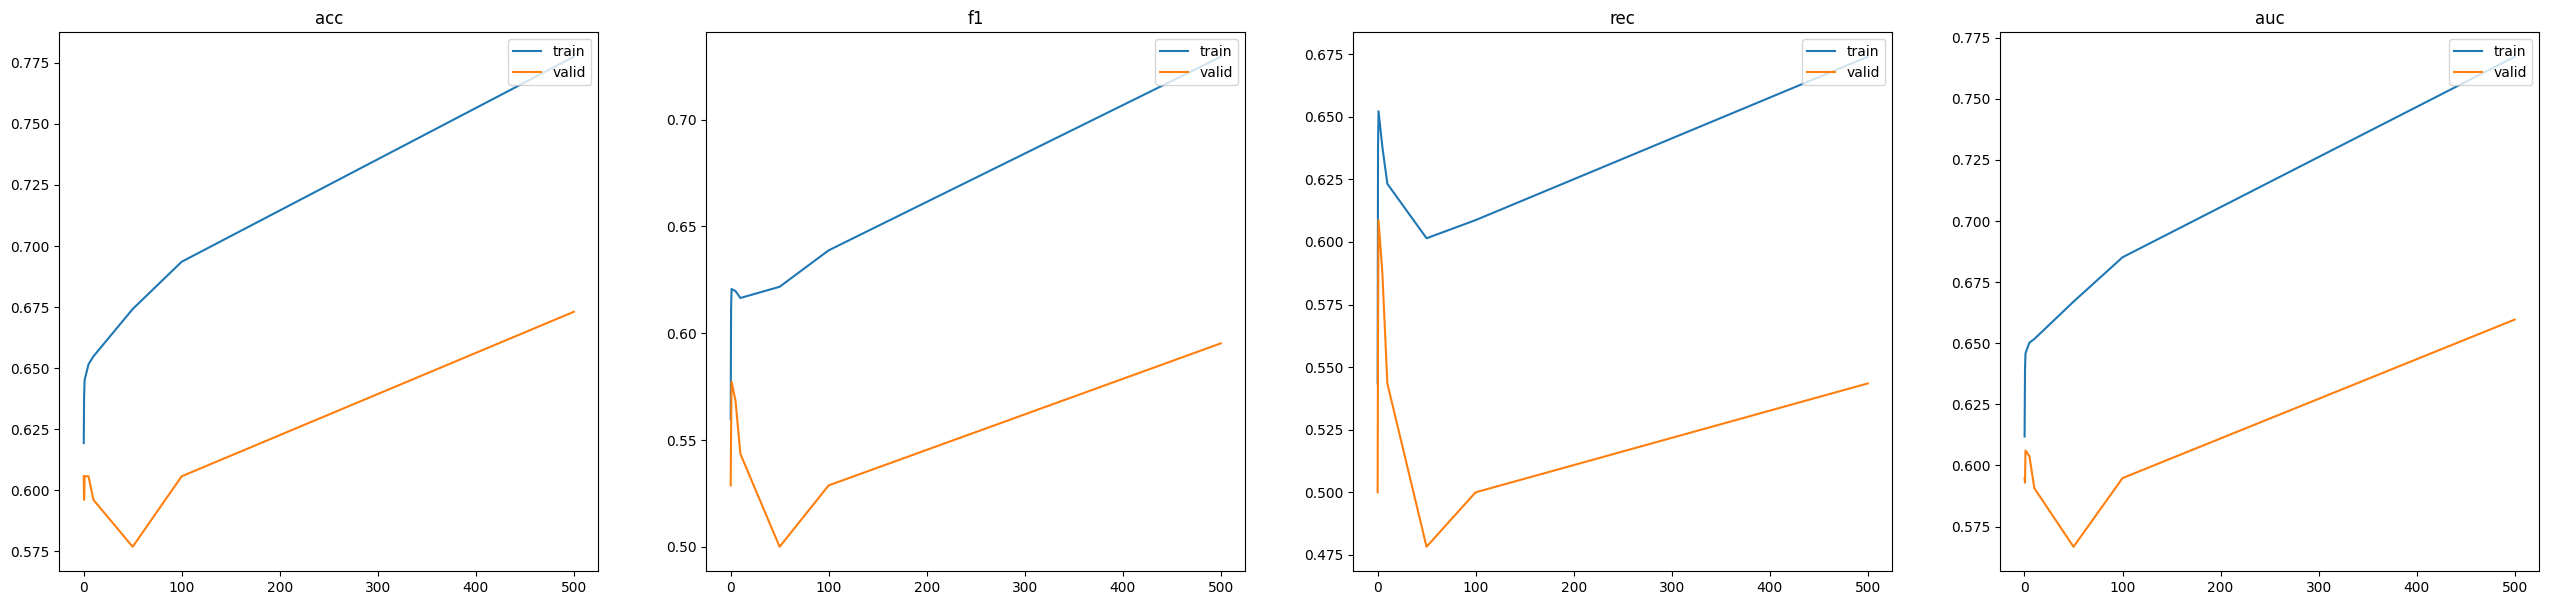

In [8]:
metric_dict = grow_tree()

C = [0.1, 0.5, 1, 5, 10, 50, 100, 500]
for c in C:
    print(f'[C = {c}]')
    svc = SVC(C = c)
    svc.fit(train_x, train_y)

    print_metrics(svc, datas)
    t_acc, t_f1, t_rec, t_auc = calculate_metrics(svc, (train_x, train_y))
    v_acc, v_f1, v_rec, v_auc = calculate_metrics(svc, (valid_x, valid_y))

    metric_dict['train']['acc'].append(t_acc)
    metric_dict['train']['f1'].append(t_f1)
    metric_dict['train']['rec'].append(t_rec)
    metric_dict['train']['auc'].append(t_auc)
    
    metric_dict['valid']['acc'].append(v_acc)
    metric_dict['valid']['f1'].append(v_f1)
    metric_dict['valid']['rec'].append(v_rec)
    metric_dict['valid']['auc'].append(v_auc)

draw_metric_graph(metric_dict, C)

[# of estimators = 75]
train score : 0.948
valid score : 0.731

[train report] 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       172
           1       0.94      0.95      0.94       138

    accuracy                           0.95       310
   macro avg       0.95      0.95      0.95       310
weighted avg       0.95      0.95      0.95       310
 

[valid report] 
              precision    recall  f1-score   support

           0       0.73      0.81      0.77        58
           1       0.72      0.63      0.67        46

    accuracy                           0.73       104
   macro avg       0.73      0.72      0.72       104
weighted avg       0.73      0.73      0.73       104

----------------------------------------------------------------------------------------------------

[# of estimators = 100]
train score : 0.977
valid score : 0.721

[train report] 
              precision    recall  f1-score   support

          

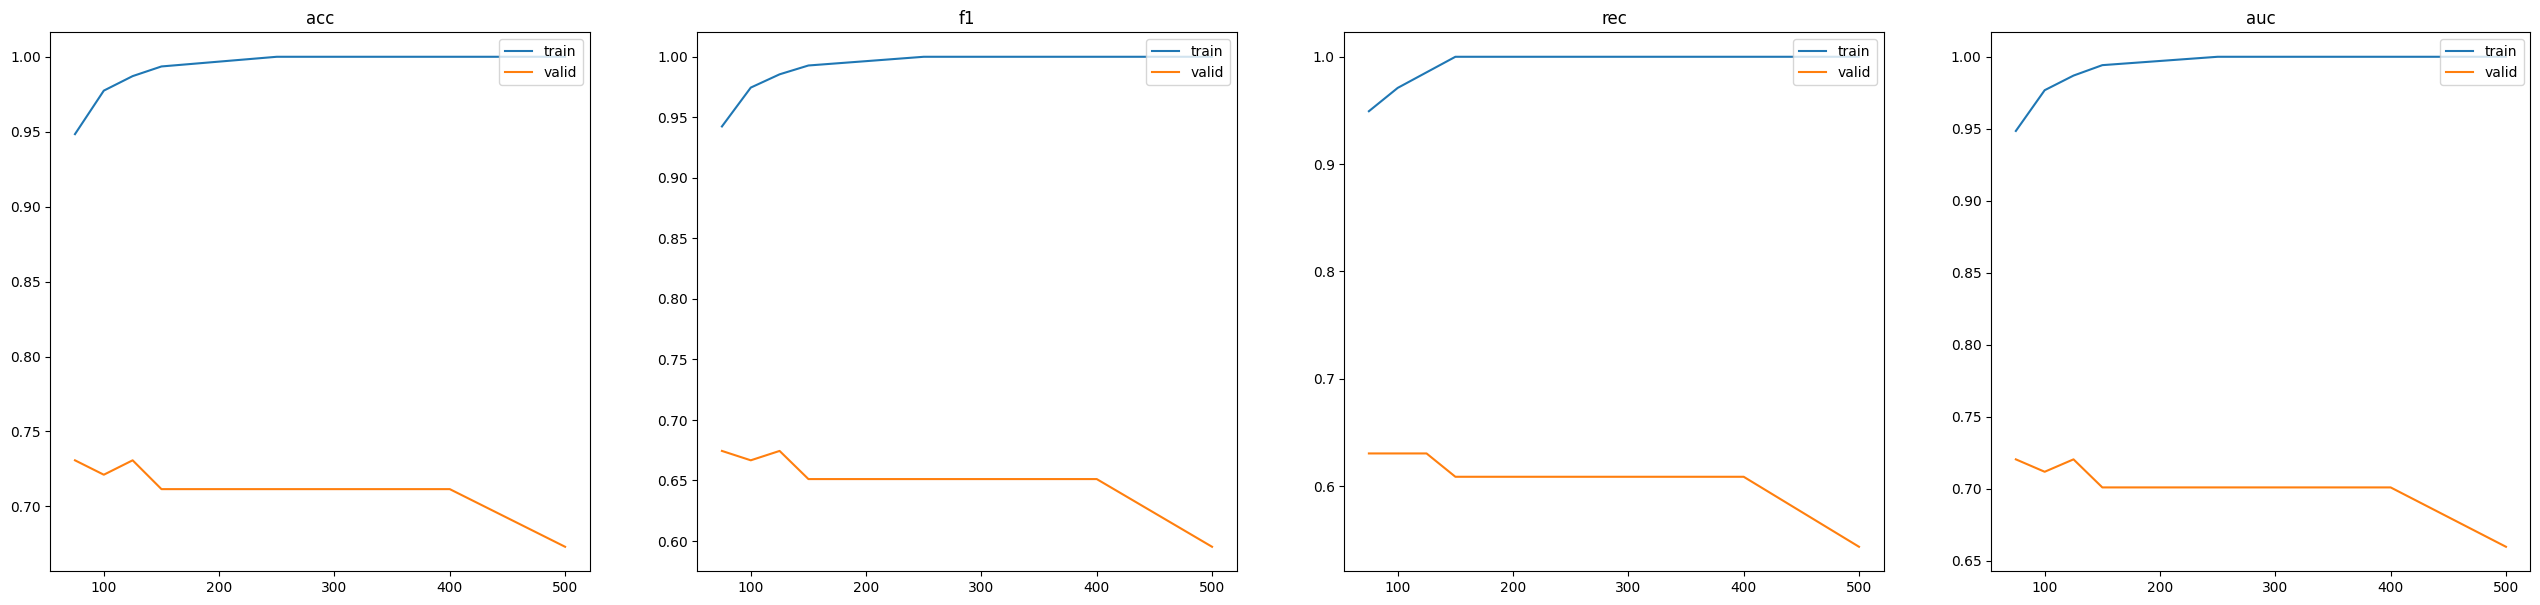

In [9]:
metric_dict = grow_tree()
N           = [75, 100, 125, 150, 200, 250, 300, 400, 500]

for n in N:

    print(f'[# of estimators = {n}]')
    boost = GradientBoostingClassifier(n_estimators = n)
    boost.fit(train_x, train_y)

    print_metrics(boost, datas)
    t_acc, t_f1, t_rec, t_auc = calculate_metrics(boost, (train_x, train_y))
    v_acc, v_f1, v_rec, v_auc = calculate_metrics(boost, (valid_x, valid_y))

    metric_dict['train']['acc'].append(t_acc)
    metric_dict['train']['f1'].append(t_f1)
    metric_dict['train']['rec'].append(t_rec)
    metric_dict['train']['auc'].append(t_auc)
    
    metric_dict['valid']['acc'].append(v_acc)
    metric_dict['valid']['f1'].append(v_f1)
    metric_dict['valid']['rec'].append(v_rec)
    metric_dict['valid']['auc'].append(v_auc)

draw_metric_graph(metric_dict, N)